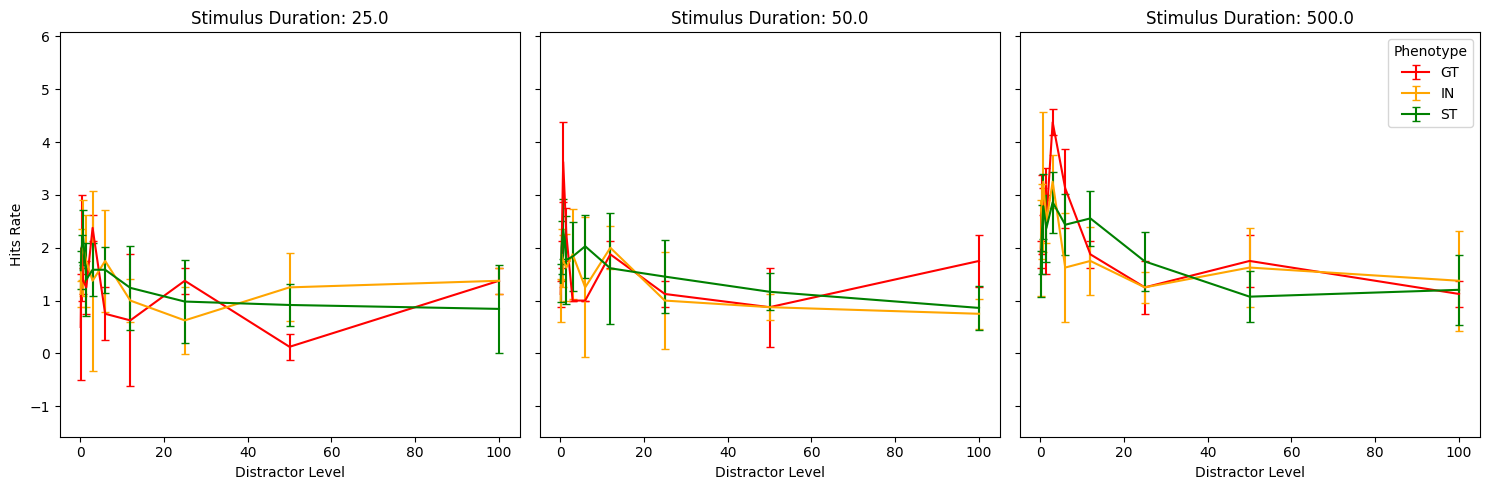

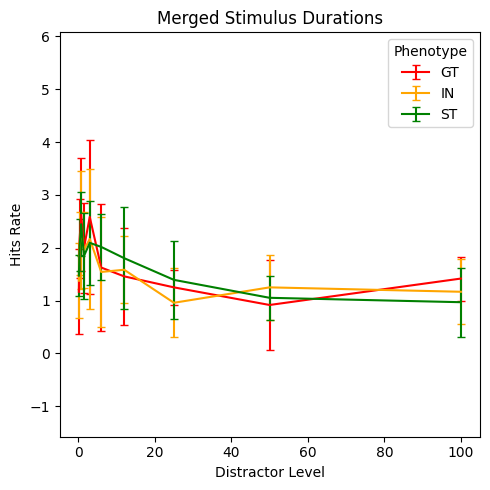

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file and the 'Tidy_Hitmiss' sheet
file_path = 'Sat9surrond.xlsx'
xls = pd.ExcelFile(file_path)
tidy_hitmiss_df = pd.read_excel(xls, sheet_name='Tidy_Hitmiss')

# Filter out necessary data
stimulus_durations = tidy_hitmiss_df['stimulus_duration'].unique()
phenotypes = tidy_hitmiss_df['phenotype'].unique()

# Prepare a dictionary to map phenotypes to colors
colors = {'ST': 'green', 'IN': 'orange', 'GT': 'red'}

# Prepare to calculate the mean and standard deviation for each combination
grouped_data = tidy_hitmiss_df.groupby(['stimulus_duration', 'Distractor_level', 'phenotype']).agg({
    'Hits': ['mean', 'std']
}).reset_index()

# Prepare for plotting
fig, axs = plt.subplots(1, len(stimulus_durations), figsize=(15, 5), sharey=True)

# Set common Y limit for all graphs
y_min = grouped_data['Hits']['mean'].min() - grouped_data['Hits']['std'].max()
y_max = grouped_data['Hits']['mean'].max() + grouped_data['Hits']['std'].max()

# Plot each stimulus duration in separate subplots
for i, duration in enumerate(stimulus_durations):
    ax = axs[i]
    
    # Filter the data for the current stimulus duration
    duration_data = grouped_data[grouped_data['stimulus_duration'] == duration]
    
    # Plot each phenotype line
    for phenotype in phenotypes:
        phenotype_data = duration_data[duration_data['phenotype'] == phenotype]
        ax.errorbar(phenotype_data['Distractor_level'], 
                    phenotype_data['Hits']['mean'], 
                    yerr=phenotype_data['Hits']['std'], 
                    label=phenotype, 
                    color=colors[phenotype], 
                    capsize=3)
    
    # Set axis labels and title
    ax.set_xlabel('Distractor Level')
    ax.set_title(f'Stimulus Duration: {duration}')
    ax.set_ylim([y_min, y_max])

# Set common Y label
axs[0].set_ylabel('Hits Rate')

# Add legend and adjust layout
axs[-1].legend(title='Phenotype')
plt.tight_layout()
plt.show()

# Now for the merged data (ignoring stimulus duration distinction)
merged_data = tidy_hitmiss_df.groupby(['Distractor_level', 'phenotype']).agg({
    'Hits': ['mean', 'std']
}).reset_index()

# Plot the merged data
plt.figure(figsize=(5, 5))

for phenotype in phenotypes:
    phenotype_data = merged_data[merged_data['phenotype'] == phenotype]
    plt.errorbar(phenotype_data['Distractor_level'], 
                 phenotype_data['Hits']['mean'], 
                 yerr=phenotype_data['Hits']['std'], 
                 label=phenotype, 
                 color=colors[phenotype], 
                 capsize=3)

plt.xlabel('Distractor Level')
plt.ylabel('Hits Rate')
plt.ylim([y_min, y_max])
plt.title('Merged Stimulus Durations')
plt.legend(title='Phenotype')
plt.tight_layout()
plt.show()


In [9]:
###Cannot handle the stimulus duration with current analysis, it is a pinguoin limitation

import pandas as pd
import pingouin as pg

# Load the Excel file and the 'Tidy_Hitmiss' sheet
file_path = 'Sat9surrond.xlsx'
xls = pd.ExcelFile(file_path)
tidy_hitmiss_df = pd.read_excel(xls, sheet_name='Tidy_Hitmiss')

# Restructure the data to make it suitable for the mixed-design ANOVA
# Factors: phenotype (between-subject), distractor level (within-subject), and stimulus duration

# Clean the data and only keep relevant columns (phenotype, Animal_ID, stimulus_duration, Distractor_level, Hits)
tidy_hitmiss_df_clean = tidy_hitmiss_df[['phenotype', 'Animal_ID', 'stimulus_duration', 'Distractor_level', 'Hits']].dropna()

# Perform a mixed-design ANOVA with Pingouin
# Between-subject factor: phenotype
# Within-subject factor: distractor level (repeated measure)
# Additional factor: stimulus duration
aov = pg.mixed_anova(dv='Hits', 
                     within='Distractor_level', 
                     between='phenotype', 
                     subject='Animal_ID', 
                     data=tidy_hitmiss_df_clean, 
                     effsize='n2')  # Generalized eta-squared effect size

# Run pairwise post-hoc comparisons with Bonferroni correction
posthoc = pg.pairwise_tests(dv='Hits', 
                            within='Distractor_level', 
                            between='phenotype', 
                            subject='Animal_ID', 
                            data=tidy_hitmiss_df_clean, 
                            padjust='bonf')  # Bonferroni correction for post-hoc

# Round the results for better readability
aov_rounded = aov.round(4)
posthoc_rounded = posthoc.round(4)

# Print the ANOVA results
print("ANOVA Results:")
print(aov_rounded)

# Print the Post-hoc results
print("\nPost-hoc Results:")
print(posthoc_rounded)

# Optionally, you can export the results to CSV files for better viewing:
aov_rounded.to_csv("anova_results.csv", index=False)
posthoc_rounded.to_csv("posthoc_results.csv", index=False)

ANOVA Results:
             Source       SS  DF1  DF2      MS        F  p-unc  p-GG-corr  \
0         phenotype   0.1705    2   14  0.0852   0.5481  0.590        NaN   
1  Distractor_level  35.6668    9  126  3.9630  30.0653  0.000        0.0   
2       Interaction   3.5481   18  126  0.1971   1.4954  0.102        NaN   

       n2     eps sphericity  W-spher  p-spher  
0  0.0029     NaN        NaN      NaN      NaN  
1  0.6131  0.5339      False   0.0014   0.0005  
2  0.0610     NaN        NaN      NaN      NaN  

Post-hoc Results:
                        Contrast Distractor_level     A     B Paired  \
0               Distractor_level                -  0.16  0.36   True   
1               Distractor_level                -  0.16  0.75   True   
2               Distractor_level                -  0.16   1.5   True   
3               Distractor_level                -  0.16   3.0   True   
4               Distractor_level                -  0.16   6.0   True   
..                           

C:\Users\pfh3221\AppData\Roaming\Python\Python38\site-packages\pingouin\parametric.py:266: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
C:\Users\pfh3221\AppData\Roaming\Python\Python38\site-packages\pingouin\parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=False, alternative=alternative)
